Steane code error correction with  noise
=================================

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up the ancilla

3. Set up the error correction circuit.  There are options to set this circuit up with and without MCT gates.

3. Because of the number of gates in the error correction circuit the error correction process itself produces considerable errors.

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np

from helper_functions import (
    count_valid_output_strings,
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    get_noise,
    mean_of_list,
    calculate_standard_error,
    print_time,
    get_parity_check_matrix,
    get_codewords
    )

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

ERROR_REDUCTION = 1
ITERATIONS = 25

NOISE = True                                              #Test with noise
SHOTS = 1000                                              #Number of shots to run 
MEASURE_NOISE = 0.0046 * ERROR_REDUCTION                  #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366 * ERROR_REDUCTION     #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022 * ERROR_REDUCTION 

SIMULATOR = Aer.get_backend('qasm_simulator')

Specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = get_parity_check_matrix()
print(parity_check_matrix)

['0001111', '0110011', '1010101']


The allowed codewords for the zero logical from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = get_codewords()
print(codewords)

['0000000', '1010101', '0110011', '1100110', '0001111', '1011010', '0111100', '1101001']


In [5]:
scenarios = {'without MCT - simple decoding':{'mct': False, 'simple': True, 'ps': False},
             'without MCT - standard decoding':{'mct': False, 'simple': False, 'ps': False},
             'without MCT - with post selection':{'mct': False, 'simple': False, 'ps': True},
             'with MCT - simple decoding':{'mct': True, 'simple': True, 'ps': False},
             'with MCT - standard decoding':{'mct': True, 'simple': False, 'ps': False},
             'with MCT - with post selection':{'mct': True, 'simple': False, 'ps': True}
            }

Error correction
-----------------------

The error correction circuit is added to the encoding circuit and ancilla and transpiled.  There are two possible circuits, those with Multi Control Toffoli (MCT) gates, and those without.

After error correction the noise is assessed.

In [6]:
#for ps in [False, True]:
for scenario, item in scenarios.items():
    mct = item['mct']
    si = item['simple']
    ps = item['ps']
    print_time()
    print(f'The results for the scenario {scenario} are:')
    simulation_result = []
    for iteration in range(ITERATIONS):
        if mct:
            qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, extend_ancilla = False)
        else:
            qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, extend_ancilla = True)
        qubit.set_up_logical_zero()
        qubit.barrier()
        qubit.barrier()
        qubit.set_up_ancilla()
        qubit.barrier()
        if mct:     #Multi Control Toffoli (MCT) gates
            qubit.correct_errors(mct = True)
            location = 2
        else:
            qubit.correct_errors()
            location = 3
        qubit.barrier()
        if NOISE:
            noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING,
                                   SINGLE_GATE_SET, TWO_GATE_SET)
        qubit.logical_measure_data()
        qubit.logical_measure_ancilla()
        qubit.barrier()
        qt = transpile(qubit, basis_gates = BASIS_GATE_SET)
        if NOISE:
            result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
        else:
            result = execute(qt, SIMULATOR, shots = SHOTS).result()
        counts = result.get_counts(qt)
        #print ('The different states can be counted.  The simulated result are', counts)
        if si:
            valid_codewords = '0'
        else:
            valid_codewords = codewords
            
        _ , count_invalid, _ = count_valid_output_strings(counts, valid_codewords, location,
                                                            post_selection = ps,
                                                            simple = si
                                                            )
        error_rate = count_invalid / SHOTS
        simulation_result.append(error_rate)
        #print(f'The error rate is {error_rate:.4f} for iteration {iteration}')
        #print_time()
    mean = mean_of_list(simulation_result) 
    standard_deviation, standard_error = calculate_standard_error(simulation_result)
    print(f'   The average error rate is {mean:.4f}.')
    print(f'   The standard deviation is {standard_deviation:.4f}') 
    print(f'   The standard error is {standard_error:.4f}')
    print()

Current Time = 11:21:44
The results for the scenario without MCT - simple decoding are:
   The average error rate is 0.4209.
   The standard deviation is 0.0193
   The standard error is 0.0039

Current Time = 11:42:44
The results for the scenario without MCT - standard decoding are:
   The average error rate is 0.7182.
   The standard deviation is 0.0159
   The standard error is 0.0032

Current Time = 12:03:05
The results for the scenario without MCT - with post selection are:
   The average error rate is 0.1300.
   The standard deviation is 0.0092
   The standard error is 0.0018

Current Time = 12:23:14
The results for the scenario with MCT - simple decoding are:
   The average error rate is 0.4868.
   The standard deviation is 0.0167
   The standard error is 0.0033

Current Time = 12:28:29
The results for the scenario with MCT - standard decoding are:
   The average error rate is 0.9217.
   The standard deviation is 0.0078
   The standard error is 0.0016

Current Time = 12:33:41
The 

Draw circuit

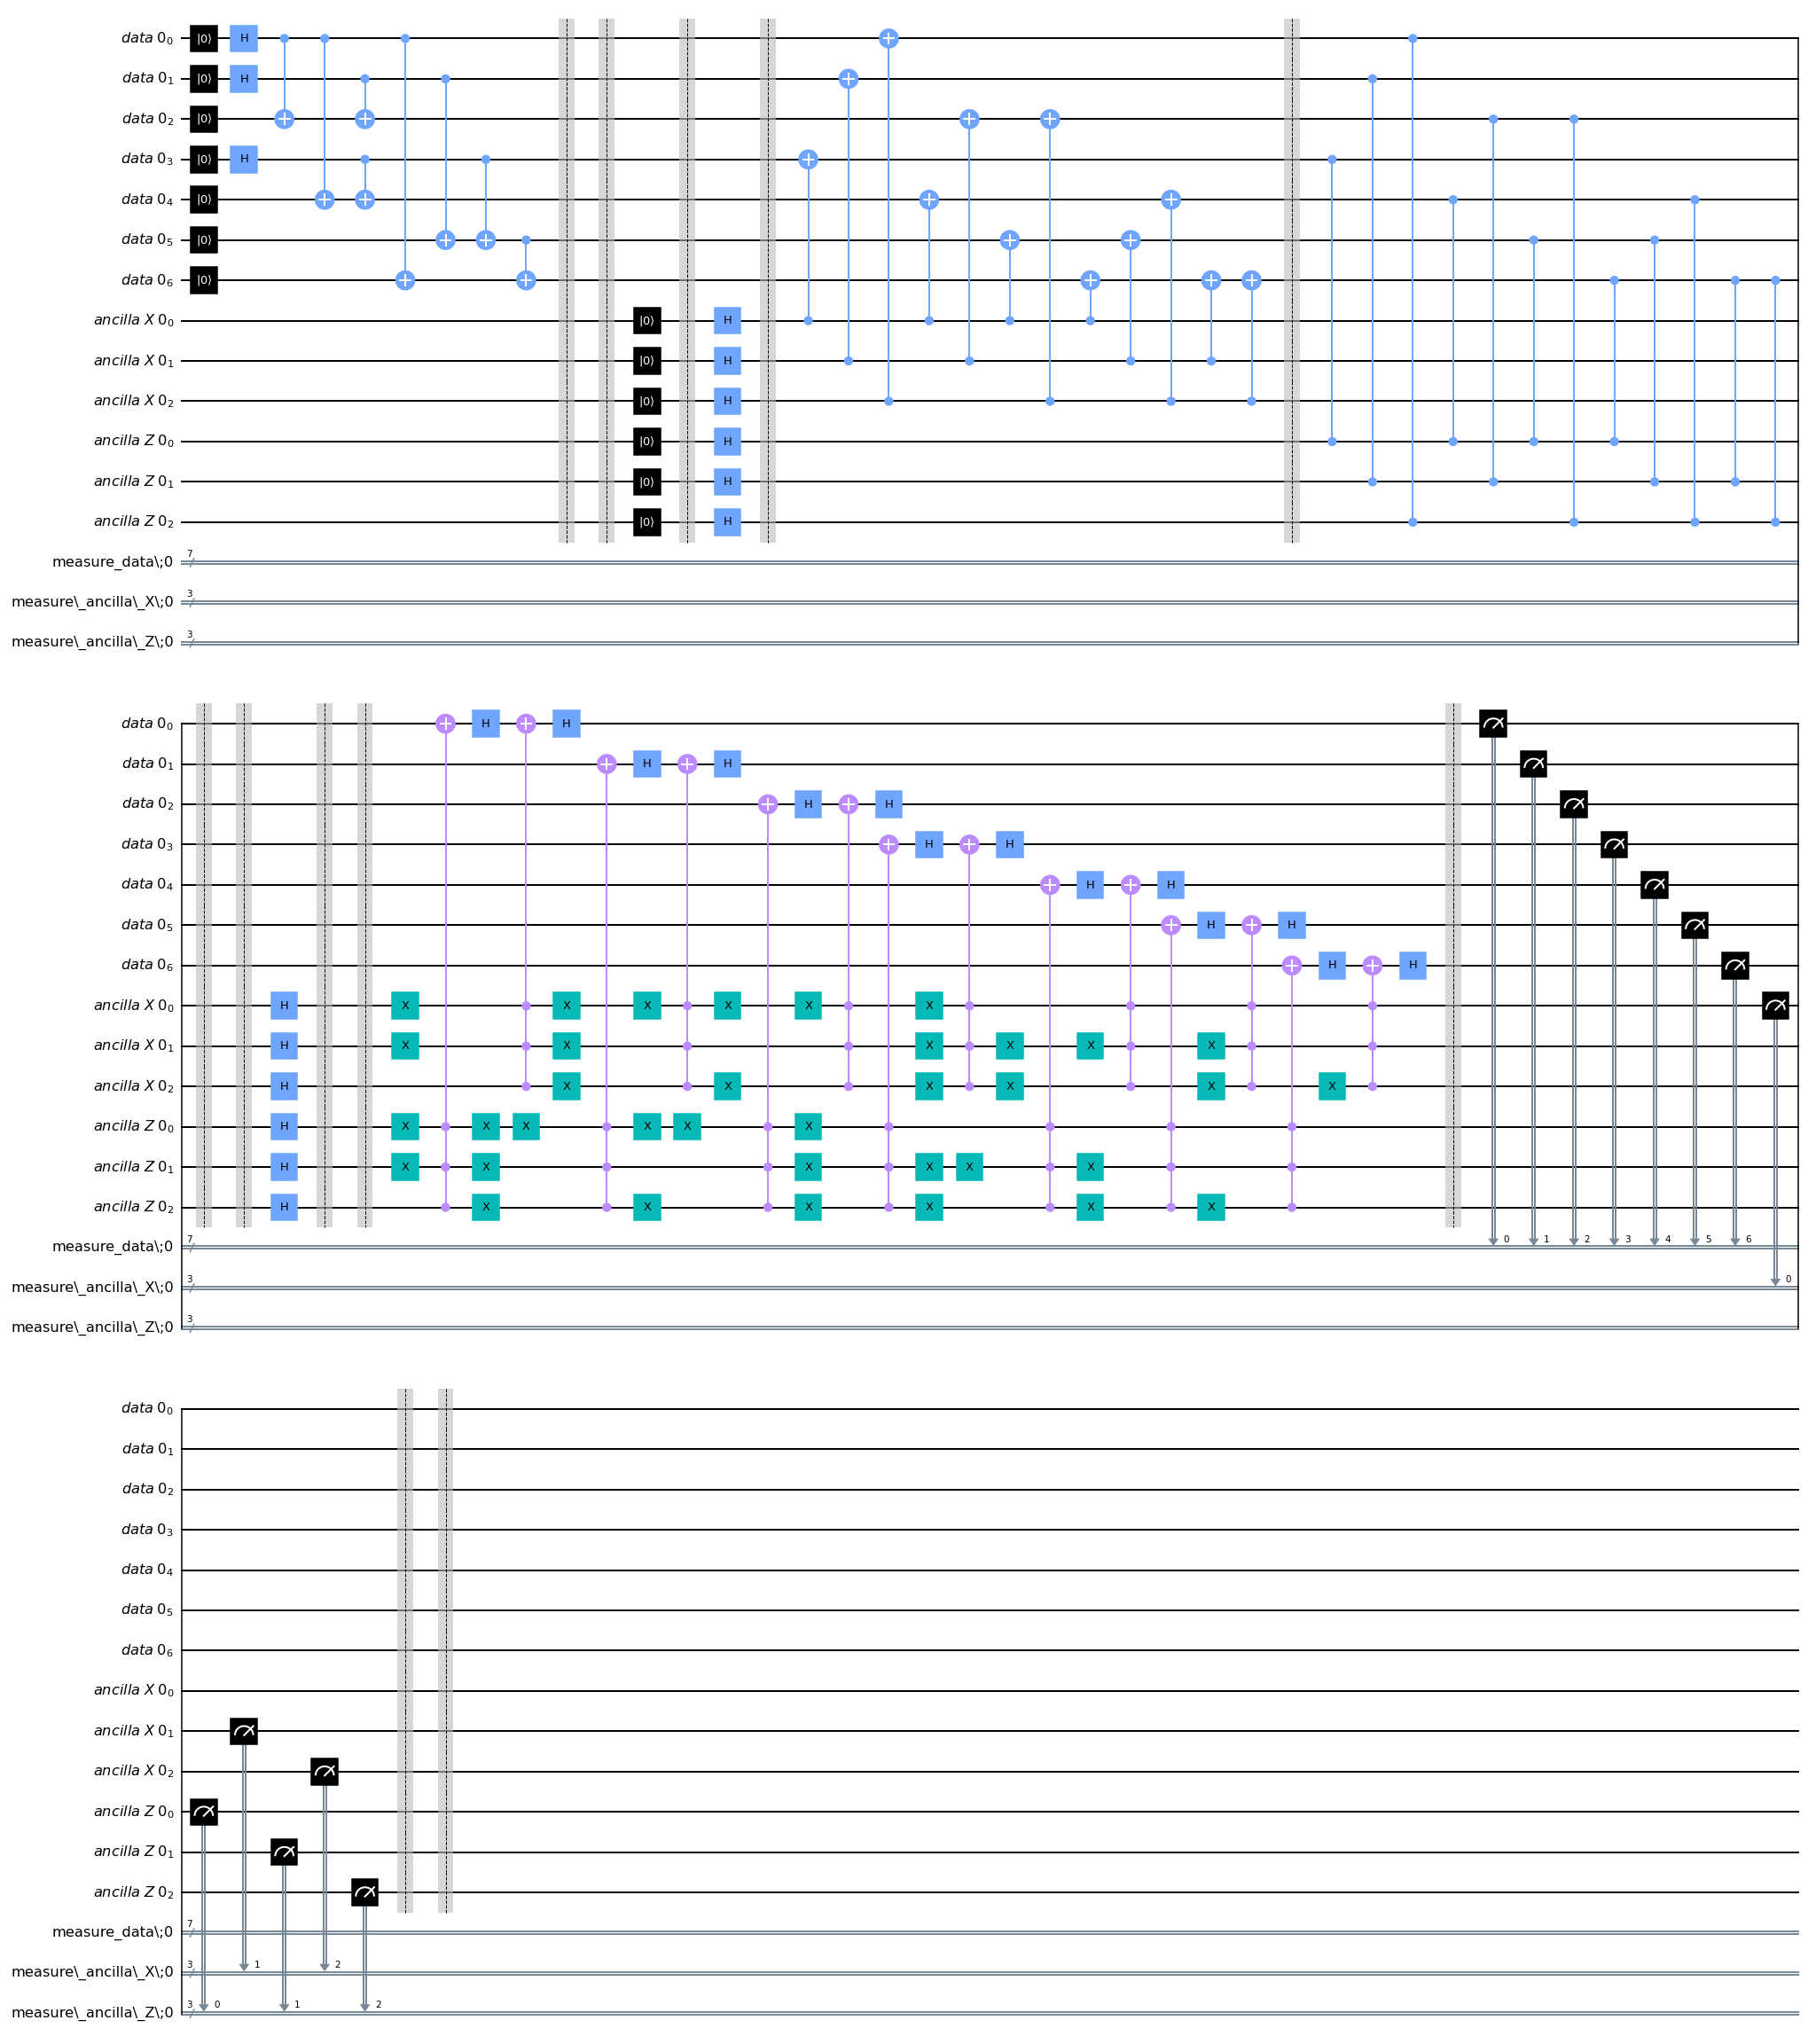

In [7]:
qubit.draw(output = 'mpl', filename = 'Steane_code_error_correction_circuit.jpg', fold = 40)

Draw transpiled circuit

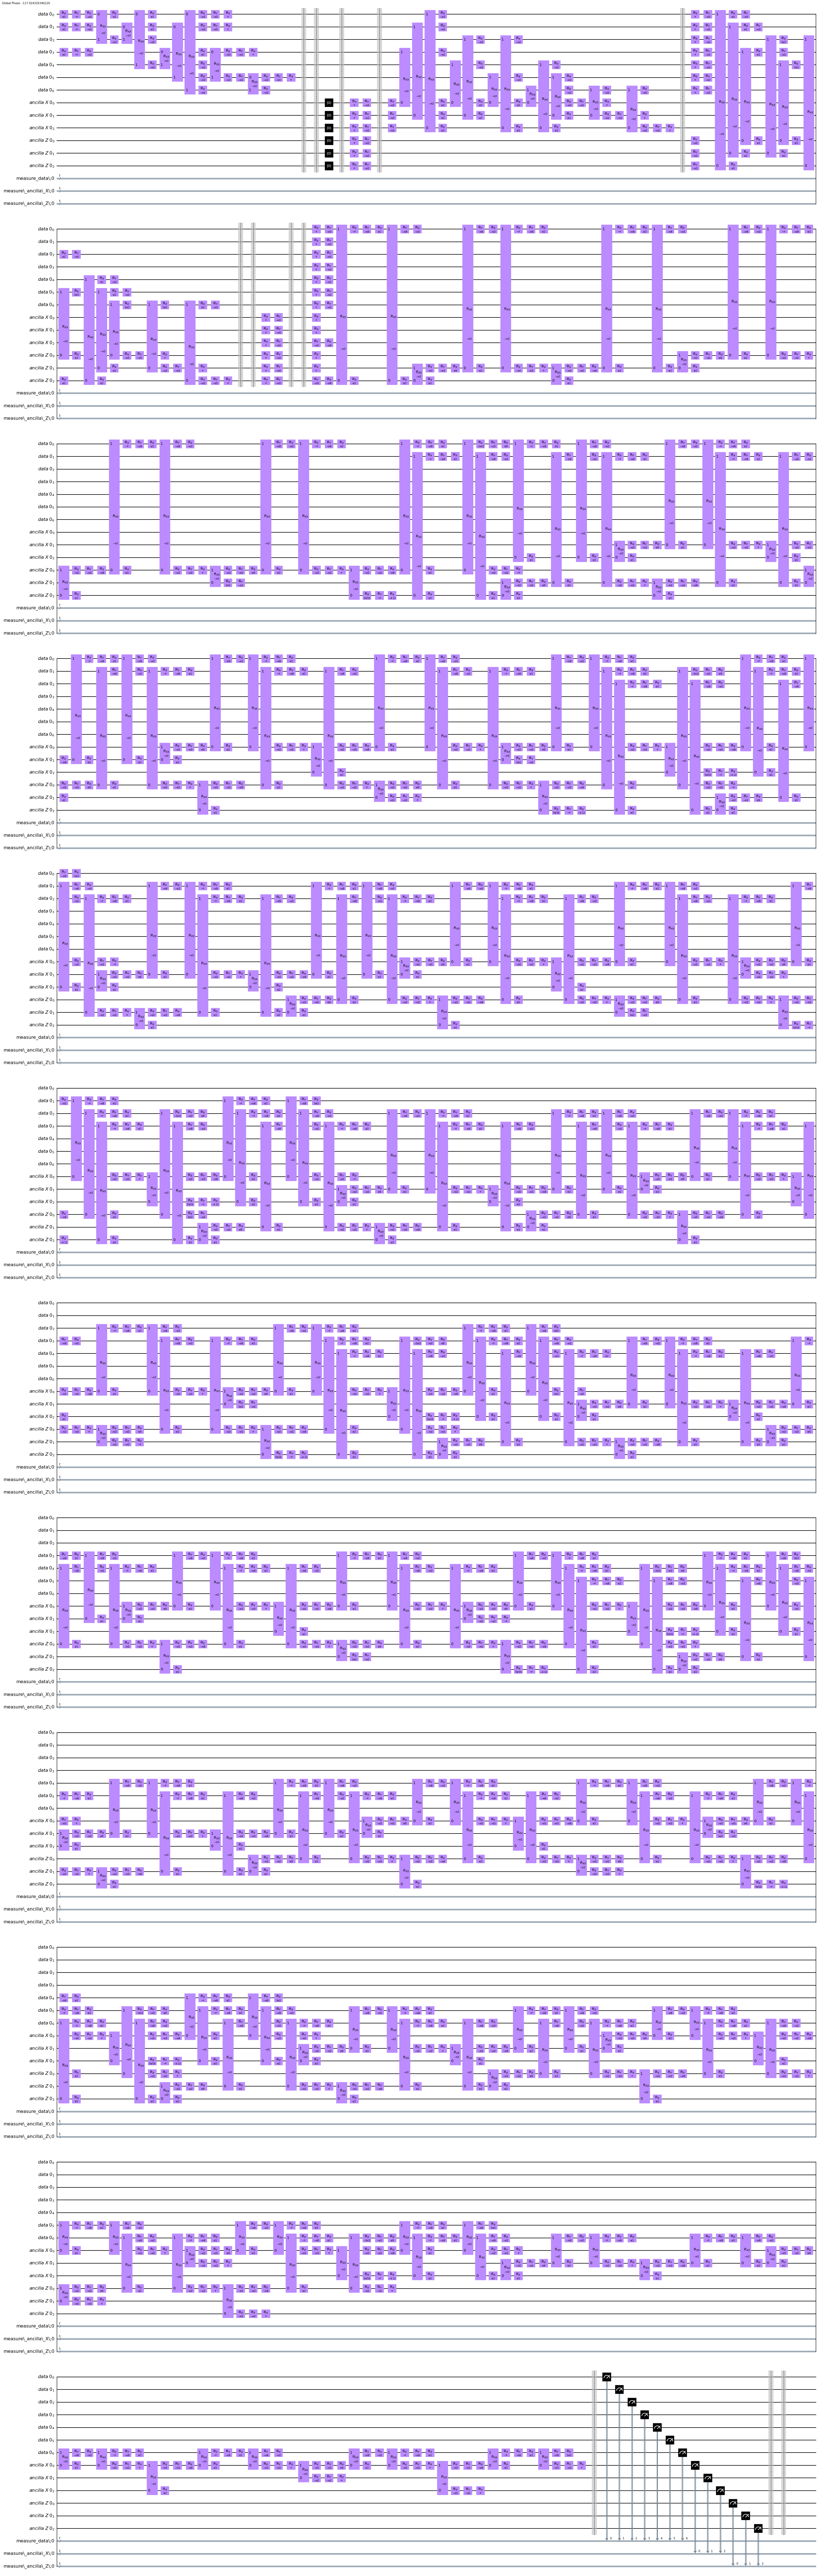

In [8]:
qt.draw(output = 'mpl', filename = 'Steane_code_error_correction_circuit_transpiled.jpg', fold = 60)